In [24]:
import numpy as np
import shutil
import cv2
import os
from matplotlib import pyplot as plt

single_folder = "data/SINGLEframes"
double_folder = "data/DOUBLEframes"

current_folder = single_folder

In [25]:
#Task 1

"""
Firstly, I converted the input color images to the grayscale images, and then used the Canny edge detection 
algorithm to find the edges of the images. Secondly I converted the input images from BGR color space to HSV color
space. The detect_court_color function defines a threshold range for detecting the color of the court and creates 
a mask based on the color range. And then it calculates the number of white pixels in the mask and the total number
of pixels in the image. It will judge whether the court exists based on the ratio of white pixels and a predefined 
threshold. The detect_quadrilateral_in_contours function finds contours in the image. For each contour, 
it calculates the perimeter and approximates the contour to a polygon. If the approximated polygon has four vertices,
it will return True. If these two functions both return True, it indicates that a badminton court is detected.
The results would be output to the folder named "source".
"""
def detect_badminton_court(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_img, 50, 150, apertureSize=3)
    imgHSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    court_color = detect_court_color(imgHSV)
    court_edge, quadrilateral = detect_quadrilateral_in_contours(edges)

    court_present = court_color and court_edge
#     return court_present, edges, quadrilateral
    return court_present


def detect_quadrilateral_in_contours(edge_image):
    contours, _ = cv2.findContours(edge_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approximation = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
        if len(approximation) == 4:
            return True, approximation
    return False, None

def detect_court_color(imgHSV, threshold=0.1):
    lower = np.array([64, 84, 74])
    upper = np.array([100, 145, 255])
    mask = cv2.inRange(imgHSV, lower, upper)
    white_pixels = np.sum(mask == 255)
    total_pixels = mask.shape[0] * mask.shape[1]
    court_ratio = white_pixels / total_pixels
    court_exists = court_ratio > threshold
    return court_exists

images_directory = current_folder
output_directory = "source"

if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    
for filename in os.listdir(images_directory):
    image_path = os.path.join(images_directory, filename)
    image = cv2.imread(image_path)
    if detect_badminton_court(image):
        cv2.imwrite(os.path.join(output_directory, filename), image)

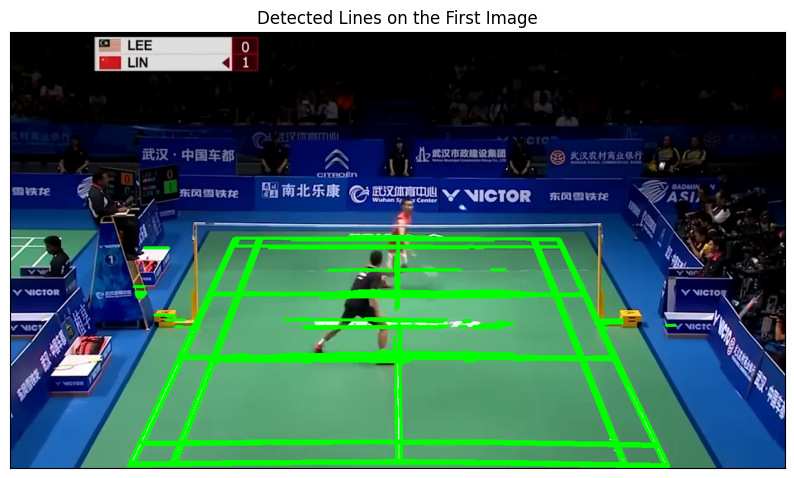

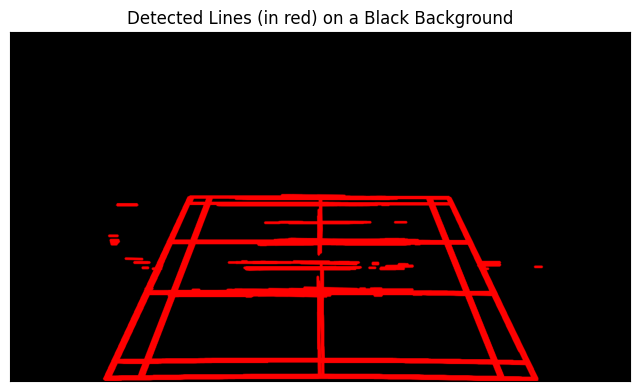

In [26]:
directory = 'source'

all_files = os.listdir(directory)

image_paths = [os.path.join(directory, f) for f in all_files if f.endswith('.jpeg') or f.endswith('.jpg')]
all_lines = []

p1 = (183, 337)
p2 = (1099, 337)
p3 = (183, 719)
p4 = (1099, 719)



for path in image_paths:
    img_org = cv2.imread(path)
    img = cv2.cvtColor(img_org, cv2.COLOR_BGR2GRAY)
    ret, th1 = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
    roi = th1[p1[1]:p4[1], p1[0]:p4[0]]
    v = np.median(roi)
    sigma = 0.33
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edges_roi = cv2.Canny(roi, 50, 150, apertureSize=3)

    linesP = cv2.HoughLinesP(edges_roi, rho=1, theta=np.pi/180, threshold=120, minLineLength=10, maxLineGap=14)
    if linesP is not None:
        for line in linesP:
            all_lines.append(line)
    
    for line in all_lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(img_org, (x1+p1[0], y1+p1[1]), (x2+p1[0], y2+p1[1]), (0, 255, 0), 3)
    cv2.imwrite('processed_source/' +path.removeprefix('source/'), img_org)

# img_org = cv.imread('1.jpeg')
for line in all_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(img_org, (x1+p1[0], y1+p1[1]), (x2+p1[0], y2+p1[1]), (0, 255, 0), 3)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB))
plt.title('Detected Lines'), plt.xticks([]), plt.yticks([])
plt.show()

modified_lines = []

if all_lines is not None:
    modified_lines = np.zeros_like(all_lines)  # Create an array with the same shape as linesP
    for i in range(len(all_lines)):
        l = all_lines[i][0]
        #  Adjustment of coordinates
        modified_line = [l[0] + p1[0], l[1] + p1[1], l[2] + p1[0], l[3] + p1[1]]
        modified_lines[i][0] = modified_line

black_background = np.zeros_like(img_org)

for line in modified_lines:
    l = line[0]  # Get a list of actual line coordinates
    x1, y1, x2, y2 = l # And then unpack these four coordinates
    cv2.line(black_background, (x1, y1), (x2, y2), (0, 0, 255), 3, cv2.LINE_AA)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(black_background, cv2.COLOR_BGR2RGB))
plt.title('Detected Lines (in red)'), plt.xticks([]), plt.yticks([])
plt.show()

In [6]:
#Task 3
'''
I used YOLOv5 to detect the athletes by adjusting some parameters such as confidence level. The source images are in the folder named "yolov5-master/data/images". And the results would be output
to the folder named "yolov5-master/runs/detect/exp".
'''
%run yolov5-master/detect.py

detect: weights=yolov5-master/yolov5s.pt, source=yolov5-master/data/images, data=yolov5-master/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.65, iou_thres=0.55, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5-master/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 2024-2-8 Python-3.9.6 torch-2.2.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/225 /Users/zhangzijun/Desktop/ultralytics/yolov5-master/data/images/frame589-DOUBLE.jpeg: 384x640 3 persons, 74.3ms
image 2/225 /Users/zhangzijun/Desktop/ultralytics/yolov5-master/data/images/frame590-DOUBLE.jpeg: 384x640 3 persons, 66.2ms
image 3/225 /Users/zhangzijun/Desktop/ultralytics/yolov5-master/data/images/frame591-DOUBLE.jpeg:

In [3]:
#Task 4
'''
First, I merged the images filtered from Task 1 into a video. Then, I used YOLOv8 to track and detect the athletes in the video. The result
video would be output to the folder named "source".
'''
import cv2
from ultralytics import YOLO

# Load the YOLOv8 model
model = YOLO('yolov8n.pt')

# Open the video file
video_path = "source/single"
cap = cv2.VideoCapture(video_path + ".avi")

fourcc = cv2.VideoWriter_fourcc('M', 'P', '4', 'V')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter(video_path + "_processed.mp4", fourcc, 20.0, (frame_width, frame_height))
while cap.isOpened():
    success, frame = cap.read()

    if success:
        results = model.track(frame, conf = 0.62, classes = [0], persist=True)

        annotated_frame = results[0].plot()

        out.write(annotated_frame)

    else:
        break

cap.release()
out.release()

/Users/zhangzijun/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'



0: 384x640 2 persons, 46.7ms
Speed: 1.5ms preprocess, 46.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 50.6ms
Speed: 1.7ms preprocess, 50.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 46.9ms
Speed: 1.1ms preprocess, 46.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 48.6ms
Speed: 1.2ms preprocess, 48.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 42.6ms
Speed: 1.1ms preprocess, 42.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 46.2ms
Speed: 1.1ms preprocess, 46.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 42.8ms
Speed: 1.1ms preprocess, 42.8ms inference, 0.5ms postprocess per image at shape (